In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

In [3]:
# 1. Load the data
df = pd.read_csv('usd_exchange_rates.csv')
df['date'] = pd.to_datetime(df['TIME_PERIOD'])
df['value'] = df['OBS_VALUE'].astype(float)
df = df.sort_values('date').reset_index(drop=True)

In [4]:
# 2. Extract values and split
values = df['value'].values.reshape(-1,1)

# 3. Train/test split by 80/20%
n = len(values)
train_size = int(n * 0.8)
train_vals = values[:train_size]
test_vals  = values[train_size:]

In [5]:
# 3. Scale based on train only
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_vals)
test_scaled  = scaler.transform(test_vals)

In [6]:
# 5. Create sliding-window sequences
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

window_size = 5
X_train, y_train = create_dataset(train_scaled, window_size)

# reshape for GRU: [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], window_size, 1))

In [7]:
# 6. Build GRU model
model = Sequential([
    GRU(50, input_shape=(window_size,1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

C:\Users\alius\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# 6. Train
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=2)

Epoch 1/50
336/336 - 7s - 20ms/step - loss: 0.0061
Epoch 2/50
336/336 - 3s - 8ms/step - loss: 1.7221e-04
Epoch 3/50
336/336 - 2s - 7ms/step - loss: 1.6596e-04
Epoch 4/50
336/336 - 2s - 7ms/step - loss: 1.6481e-04
Epoch 5/50
336/336 - 2s - 5ms/step - loss: 1.5563e-04
Epoch 6/50
336/336 - 2s - 6ms/step - loss: 1.5436e-04
Epoch 7/50
336/336 - 2s - 6ms/step - loss: 1.5052e-04
Epoch 8/50
336/336 - 2s - 5ms/step - loss: 1.4013e-04
Epoch 9/50
336/336 - 2s - 5ms/step - loss: 1.4218e-04
Epoch 10/50
336/336 - 2s - 5ms/step - loss: 1.3255e-04
Epoch 11/50
336/336 - 2s - 5ms/step - loss: 1.3305e-04
Epoch 12/50
336/336 - 2s - 5ms/step - loss: 1.1881e-04
Epoch 13/50
336/336 - 2s - 6ms/step - loss: 1.2613e-04
Epoch 14/50
336/336 - 2s - 5ms/step - loss: 1.2210e-04
Epoch 15/50
336/336 - 1s - 3ms/step - loss: 1.2285e-04
Epoch 16/50
336/336 - 1s - 4ms/step - loss: 1.1704e-04
Epoch 17/50
336/336 - 2s - 5ms/step - loss: 1.1550e-04
Epoch 18/50
336/336 - 2s - 5ms/step - loss: 1.1144e-04
Epoch 19/50
336/336 - 

In [9]:
# 7. Make one-step-ahead forecasts over the test set
history = list(train_scaled.flatten())
predictions_scaled = []
for t in range(len(test_scaled)):
    seq_input = np.array(history[-window_size:]).reshape(1, window_size, 1)
    yhat = model.predict(seq_input, verbose=0)[0,0]
    predictions_scaled.append(yhat)
    # use actual next value to feed the window (one-step forecasting)
    history.append(test_scaled[t,0])

predictions_scaled = np.array(predictions_scaled).reshape(-1,1)

In [10]:
# 8. Inverse‐scale
predictions = scaler.inverse_transform(predictions_scaled)
actual_test = scaler.inverse_transform(test_scaled)

In [11]:
# 9. Evaluation
mse  = mean_squared_error(actual_test, predictions)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(actual_test, predictions)
mape = np.mean(np.abs((actual_test - predictions) / actual_test)) * 100

print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE:  {mae:.6f}")
print(f"MAPE: {mape:.2f}%")

MSE:  0.000028
RMSE: 0.005259
MAE:  0.003899
MAPE: 0.36%


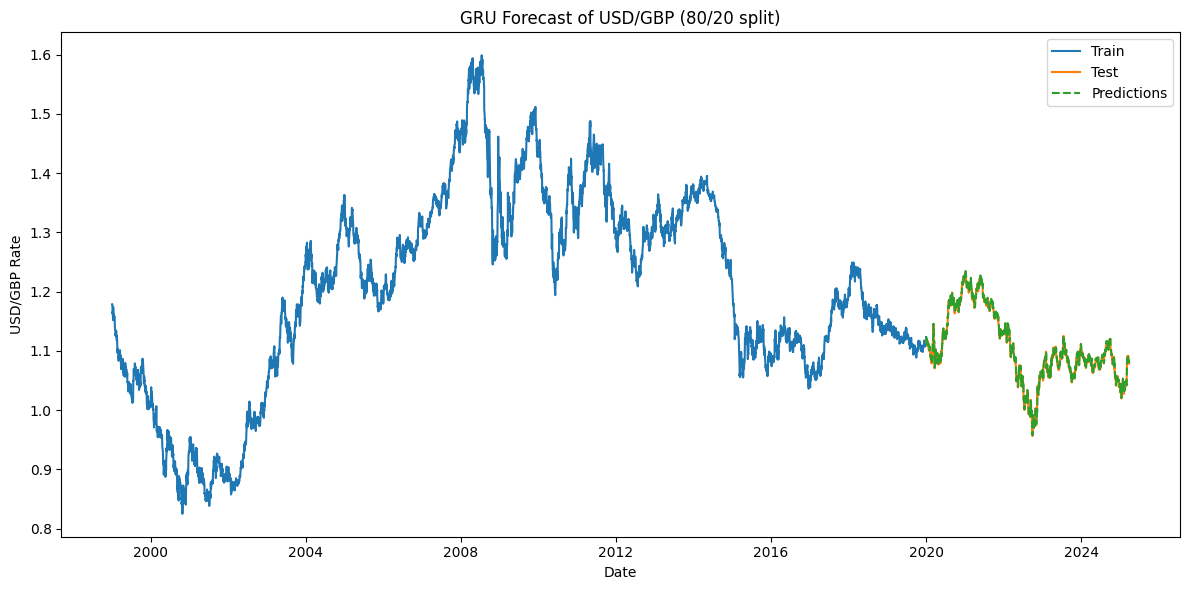

In [12]:
# 11. Plot train, test, predictions
plt.figure(figsize=(12,6))
# training series
plt.plot(df['date'][:train_size], train_vals.flatten(),   label='Train')
# testing series
plt.plot(df['date'][train_size:], actual_test.flatten(),  label='Test')
# model forecasts
plt.plot(df['date'][train_size:], predictions.flatten(), label='Predictions', linestyle='--')

plt.xlabel('Date')
plt.ylabel('USD/GBP Rate')
plt.title('GRU Forecast of EUR/USD')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# 12. Save predictions + actuals to CSV
result_df = pd.DataFrame({
    'date':   df['date'][train_size:].values,
    'actual': actual_test.flatten(),
    'predicted': predictions.flatten()
})

result_df.to_csv('gru_forecast_output.csv', index=False)
print("GRU forecast results saved to 'gru_forecast_output.csv'")



GRU forecast results saved to 'gru_forecast_output.csv'
